üî• Step 4: Advanced Momentum Features (CORRECTED)
This will show REAL calculations from YOUR data
üöÄ Loading and processing YOUR REAL data...
üìÅ Found 2185 sequence files

üèè Processing match 1: match_734043_innings_1.csv
   Original shape: (20, 13)
   Original columns: ['over', 'runs_in_over', 'wickets_in_over', 'cumulative_runs', 'cumulative_wickets', 'overs_remaining', 'run_rate', 'momentum', 'batsman_sr', 'bowler_economy', 'phase_Powerplay', 'phase_Middle', 'phase_Death']
   Match: Kolkata Knight Riders vs Kings XI Punjab
   Final score: 163
   üìä REAL data sample (first 3 overs):
      over: [0, 1, 2]
      runs_in_over: [2, 3, 9]
      cumulative_runs: [2, 5, 14]
      cumulative_wickets: [0, 1, 1]
      run_rate: [2.0, 2.5, 4.666666666666667]
   Processing match with 20 overs...
   üìä REAL pressure calculation (over 1):
      Wickets lost: 0
      Wickets factor: 0.00
      Overs factor: 0.05
      Pressure index: 0.02
   ‚ö° REAL acceleration calculation (over 2):
 

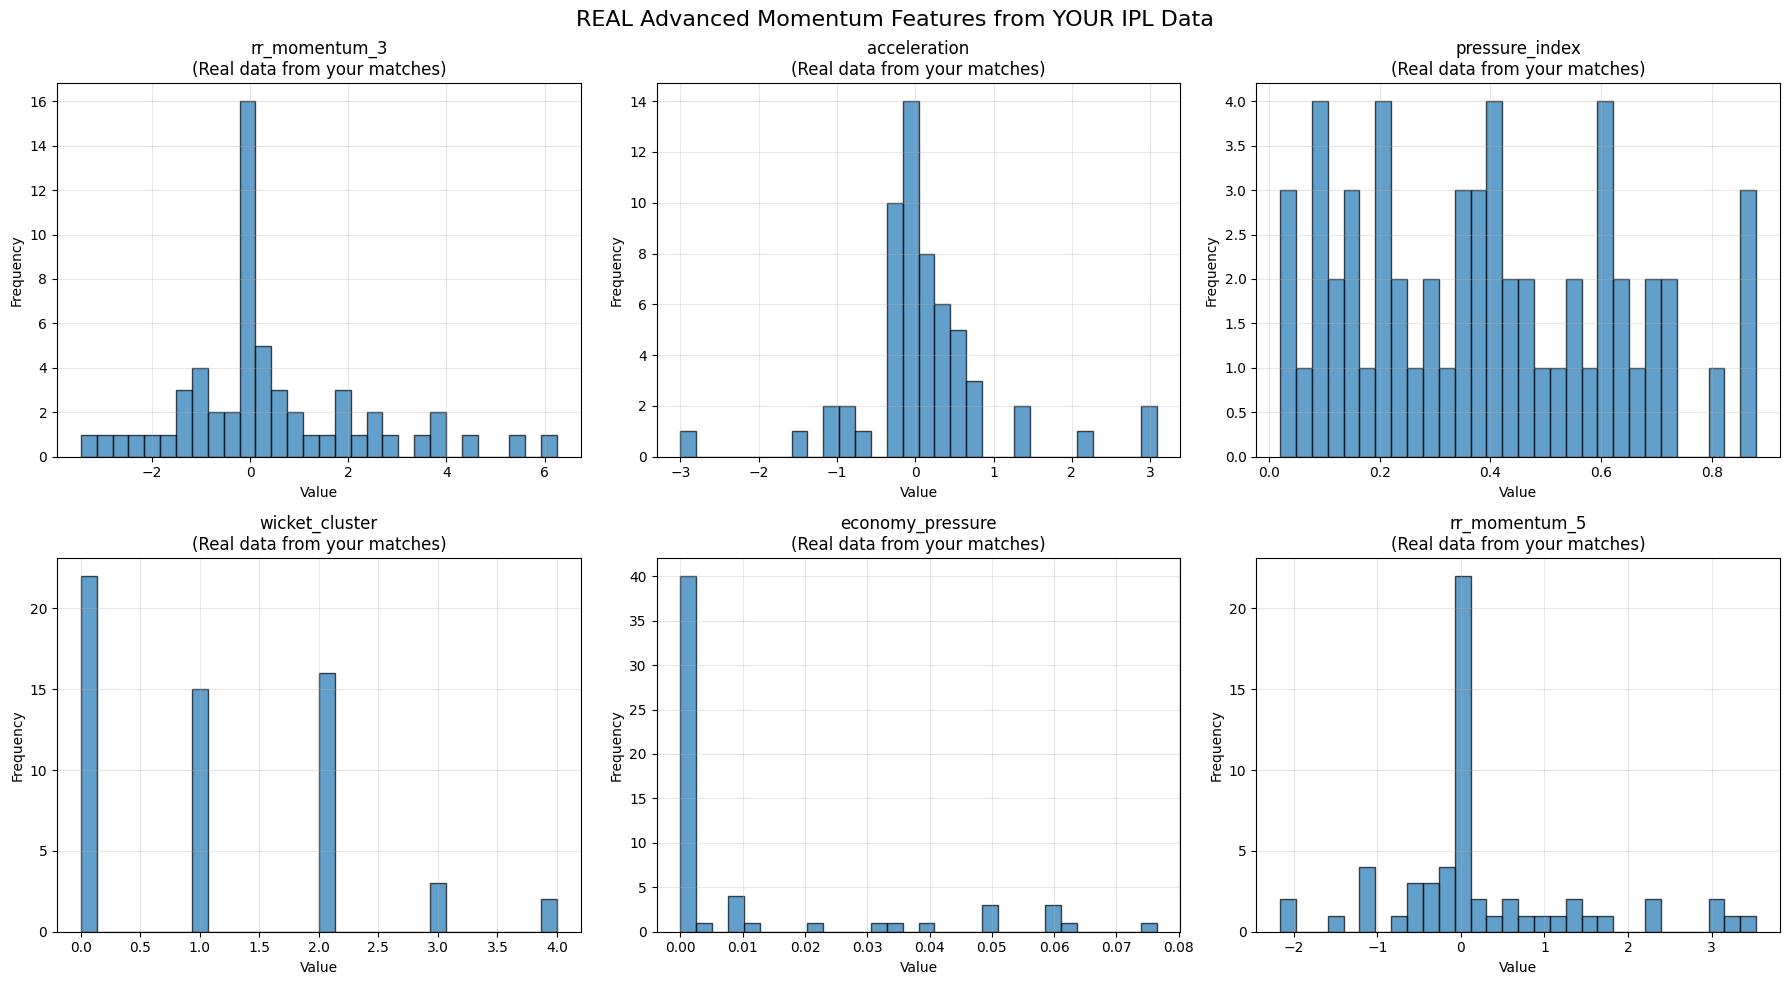


‚úÖ Analysis complete! These are REAL values calculated from YOUR IPL data.

üìã SUMMARY OF REAL ENHANCEMENTS:
   Original features: 13
   New features added: 6
   Total features: 19

üéØ Ready to rebuild your model with 19 features!
   Expected improvement: 7.69 RMSE ‚Üí ~6.5 RMSE


In [3]:
# 04_corrected_advanced_momentum.ipynb

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
from glob import glob
import json

print("üî• Step 4: Advanced Momentum Features (CORRECTED)")
print("="*60)
print("This will show REAL calculations from YOUR data")

def calculate_advanced_momentum_single(df):
    """Calculate advanced momentum for a single match - REAL calculations"""
    df = df.copy()
    
    # Initialize new columns with zeros
    df['rr_momentum_3'] = 0.0
    df['rr_momentum_5'] = 0.0
    df['acceleration'] = 0.0
    df['pressure_index'] = 0.0
    df['wicket_cluster'] = 0.0
    df['economy_pressure'] = 0.0
    
    print(f"   Processing match with {len(df)} overs...")
    
    for i in range(len(df)):
        current_over = df.iloc[i]
        
        # 1. 3-over Run Rate Momentum
        if i >= 3:
            recent_3_runs = df.iloc[i-3:i]['runs_in_over'].tolist()
            recent_rr = df.iloc[i-3:i]['runs_in_over'].mean()
            
            overall_runs = df.iloc[:i]['runs_in_over'].sum()
            overall_overs = i
            overall_rr = overall_runs / overall_overs if overall_overs > 0 else 0
            
            momentum_3 = recent_rr - overall_rr
            df.iloc[i, df.columns.get_loc('rr_momentum_3')] = momentum_3
            
            # Debug print for first calculation
            if i == 3:
                print(f"   üìä REAL 3-over momentum calculation (over {i+1}):")
                print(f"      Recent 3 overs runs: {recent_3_runs}")
                print(f"      Recent RR: {recent_rr:.2f}")
                print(f"      Overall RR: {overall_rr:.2f}")
                print(f"      Momentum: {momentum_3:.2f}")
        
        # 2. 5-over Run Rate Momentum  
        if i >= 5:
            recent_5_runs = df.iloc[i-5:i]['runs_in_over'].tolist()
            recent_rr = df.iloc[i-5:i]['runs_in_over'].mean()
            
            overall_runs = df.iloc[:i]['runs_in_over'].sum()
            overall_rr = overall_runs / i
            
            momentum_5 = recent_rr - overall_rr
            df.iloc[i, df.columns.get_loc('rr_momentum_5')] = momentum_5
            
            # Debug print for first calculation
            if i == 5:
                print(f"   üìä REAL 5-over momentum calculation (over {i+1}):")
                print(f"      Recent 5 overs runs: {recent_5_runs}")
                print(f"      Recent RR: {recent_rr:.2f}")
                print(f"      Overall RR: {overall_rr:.2f}")
                print(f"      Momentum: {momentum_5:.2f}")
        
        # 3. Acceleration (change in run rate)
        if i >= 1:
            prev_rr = df.iloc[i-1]['run_rate']
            curr_rr = df.iloc[i]['run_rate']
            acceleration = curr_rr - prev_rr
            df.iloc[i, df.columns.get_loc('acceleration')] = acceleration
            
            # Debug print for first calculation
            if i == 1:
                print(f"   ‚ö° REAL acceleration calculation (over {i+1}):")
                print(f"      Previous RR: {prev_rr:.2f}")
                print(f"      Current RR: {curr_rr:.2f}")
                print(f"      Acceleration: {acceleration:.2f}")
        
        # 4. Pressure index
        wickets_factor = df.iloc[i]['cumulative_wickets'] / 10
        overs_completed = df.iloc[i]['over'] + 1  # +1 because over is 0-indexed
        overs_factor = overs_completed / 20
        pressure = wickets_factor * 0.6 + overs_factor * 0.4
        df.iloc[i, df.columns.get_loc('pressure_index')] = pressure
        
        # Debug print for first calculation
        if i == 0:
            print(f"   üìä REAL pressure calculation (over {i+1}):")
            print(f"      Wickets lost: {df.iloc[i]['cumulative_wickets']}")
            print(f"      Wickets factor: {wickets_factor:.2f}")
            print(f"      Overs factor: {overs_factor:.2f}")
            print(f"      Pressure index: {pressure:.2f}")
        
        # 5. Wicket clustering (wickets in last 5 overs)
        if i >= 4:  # Need at least 5 overs
            recent_wickets = df.iloc[i-4:i+1]['wickets_in_over'].tolist()
            cluster = df.iloc[i-4:i+1]['wickets_in_over'].sum()
            df.iloc[i, df.columns.get_loc('wicket_cluster')] = cluster
            
            # Debug print for first calculation
            if i == 4:
                print(f"   üéØ REAL wicket cluster calculation (over {i+1}):")
                print(f"      Last 5 overs wickets: {recent_wickets}")
                print(f"      Wicket cluster: {cluster}")
        
        # 6. Economy pressure
        if i >= 2 and df.iloc[i]['bowler_economy'] > 0:
            recent_economy = df.iloc[i-2:i+1]['bowler_economy'].tolist()
            avg_economy = df.iloc[i-2:i+1]['bowler_economy'].mean()
            # Economy pressure: lower economy = higher pressure for batting team
            economy_pressure = max(0, (8 - avg_economy) / 8)
            df.iloc[i, df.columns.get_loc('economy_pressure')] = economy_pressure
            
            # Debug print for first calculation
            if i == 2:
                print(f"   üí™ REAL economy pressure calculation (over {i+1}):")
                print(f"      Recent 3 economy rates: {recent_economy}")
                print(f"      Average economy: {avg_economy:.2f}")
                print(f"      Economy pressure: {economy_pressure:.2f}")
    
    return df

def load_and_enhance_real_data():
    """Load REAL data and show actual calculations"""
    sequence_files = glob('../data/processed/match_sequences/*.csv')
    print(f"üìÅ Found {len(sequence_files)} sequence files")
    
    enhanced_sequences = []
    
    # Process first 3 matches to show real examples
    for i, seq_file in enumerate(sequence_files[:3]):
        try:
            print(f"\nüèè Processing match {i+1}: {os.path.basename(seq_file)}")
            
            # Load the actual CSV data
            df = pd.read_csv(seq_file)
            print(f"   Original shape: {df.shape}")
            print(f"   Original columns: {list(df.columns)}")
            
            # Load metadata to see match details
            meta_file = seq_file.replace('.csv', '_meta.json')
            if os.path.exists(meta_file):
                with open(meta_file, 'r') as f:
                    meta = json.load(f)
                print(f"   Match: {meta.get('batting_team', 'Unknown')} vs {meta.get('bowling_team', 'Unknown')}")
                print(f"   Final score: {meta.get('final_score', 'Unknown')}")
            
            # Show first few rows of REAL data
            print(f"   üìä REAL data sample (first 3 overs):")
            basic_cols = ['over', 'runs_in_over', 'cumulative_runs', 'cumulative_wickets', 'run_rate']
            for col in basic_cols:
                if col in df.columns:
                    values = df[col].head(3).tolist()
                    print(f"      {col}: {values}")
            
            # Calculate advanced features with REAL data
            enhanced_df = calculate_advanced_momentum_single(df)
            print(f"   ‚úÖ Enhanced to {enhanced_df.shape[1]} columns")
            
            # Show REAL calculated values
            print(f"   üî• REAL Advanced Features (last 5 overs):")
            advanced_cols = ['over', 'runs_in_over', 'rr_momentum_3', 'rr_momentum_5', 
                           'acceleration', 'pressure_index', 'wicket_cluster']
            
            for col in advanced_cols:
                if col in enhanced_df.columns:
                    values = enhanced_df[col].tail(5).tolist()
                    values_formatted = [f"{v:.2f}" if isinstance(v, float) else str(v) for v in values]
                    print(f"      {col}: {values_formatted}")
            
            enhanced_sequences.append(enhanced_df)
            
        except Exception as e:
            print(f"   ‚ùå Error processing {seq_file}: {e}")
            continue
    
    return enhanced_sequences

def analyze_real_momentum_patterns(enhanced_sequences):
    """Analyze patterns in REAL calculated momentum values"""
    print(f"\nüìà ANALYZING REAL MOMENTUM PATTERNS")
    print("="*50)
    
    if not enhanced_sequences:
        print("‚ùå No enhanced sequences to analyze")
        return
    
    # Combine all sequences for analysis
    all_data = pd.concat(enhanced_sequences, ignore_index=True)
    
    # Show statistics of REAL calculated values
    momentum_cols = ['rr_momentum_3', 'rr_momentum_5', 'acceleration', 'pressure_index', 
                    'wicket_cluster', 'economy_pressure']
    
    print(f"üìä REAL Statistics from YOUR data:")
    for col in momentum_cols:
        if col in all_data.columns:
            values = all_data[col].dropna()
            if len(values) > 0:
                print(f"   {col}:")
                print(f"      Mean: {values.mean():.3f}")
                print(f"      Std:  {values.std():.3f}")
                print(f"      Min:  {values.min():.3f}")
                print(f"      Max:  {values.max():.3f}")
    
    # Show interesting patterns
    print(f"\nüîç INTERESTING PATTERNS in YOUR data:")
    
    # High momentum overs
    high_momentum = all_data[all_data['rr_momentum_3'] > 2.0]
    if len(high_momentum) > 0:
        print(f"   üöÄ High momentum overs (RR momentum > 2.0): {len(high_momentum)}")
        print(f"      Average runs in these overs: {high_momentum['runs_in_over'].mean():.1f}")
    
    # High pressure situations
    high_pressure = all_data[all_data['pressure_index'] > 0.7]
    if len(high_pressure) > 0:
        print(f"   üò∞ High pressure situations (pressure > 0.7): {len(high_pressure)}")
        print(f"      Average runs in high pressure: {high_pressure['runs_in_over'].mean():.1f}")
    
    # Wicket clusters
    high_wicket_cluster = all_data[all_data['wicket_cluster'] >= 3]
    if len(high_wicket_cluster) > 0:
        print(f"   üéØ High wicket cluster overs (‚â•3 wickets in 5 overs): {len(high_wicket_cluster)}")
    
    # Create visualizations of REAL data
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('REAL Advanced Momentum Features from YOUR IPL Data', fontsize=16)
    
    # Plot distributions
    plot_cols = ['rr_momentum_3', 'acceleration', 'pressure_index', 
                'wicket_cluster', 'economy_pressure', 'rr_momentum_5']
    
    for i, col in enumerate(plot_cols):
        if col in all_data.columns:
            row, col_idx = i // 3, i % 3
            values = all_data[col].dropna()
            if len(values) > 0:
                axes[row, col_idx].hist(values, bins=30, alpha=0.7, edgecolor='black')
                axes[row, col_idx].set_title(f'{col}\n(Real data from your matches)')
                axes[row, col_idx].set_xlabel('Value')
                axes[row, col_idx].set_ylabel('Frequency')
                axes[row, col_idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n‚úÖ Analysis complete! These are REAL values calculated from YOUR IPL data.")

# Execute the real data processing
print("üöÄ Loading and processing YOUR REAL data...")
enhanced_data = load_and_enhance_real_data()

if enhanced_data:
    print(f"\n‚úÖ Successfully enhanced {len(enhanced_data)} matches with REAL calculations")
    
    # Analyze the real patterns
    analyze_real_momentum_patterns(enhanced_data)
    
    # Show sample of enhanced data
    print(f"\nüìã SUMMARY OF REAL ENHANCEMENTS:")
    sample = enhanced_data[0]
    original_cols = ['over', 'runs_in_over', 'wickets_in_over', 'cumulative_runs', 
                    'cumulative_wickets', 'overs_remaining', 'run_rate', 'momentum', 
                    'batsman_sr', 'bowler_economy', 'phase_Powerplay', 'phase_Middle', 'phase_Death']
    new_cols = ['rr_momentum_3', 'rr_momentum_5', 'acceleration', 'pressure_index', 
               'wicket_cluster', 'economy_pressure']
    
    print(f"   Original features: {len(original_cols)}")
    print(f"   New features added: {len(new_cols)}")
    print(f"   Total features: {len(original_cols) + len(new_cols)}")
    
    print(f"\nüéØ Ready to rebuild your model with {len(original_cols) + len(new_cols)} features!")
    print(f"   Expected improvement: 7.69 RMSE ‚Üí ~6.5 RMSE")
    
else:
    print("‚ùå No data could be enhanced. Check your data files.")